In [1]:
#most python scripts start with 'import' statements like this that make useful packages available. 
#Examples are 'uproot' which reads in our data files and allows them to be read, 'numpy' is a powerful 
#and popular package for fast manipultation of arrays and 'scipy.stats' is useful for statitical analysis,
#we'll use it to generate and fit fucntions to our data.
import lorentz
import uproot
import uproot_methods.classes.TLorentzVector as LVepm
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import cauchy
import pandas as pd

In [190]:
#the first thing we want to do is read our data file.
%time
eventsData = uproot.open("data_Skim_mumu.root")["mini"] #this command tells uproot where to find the file
#here the file is converted into the very poweful 'pandas dataframe' format which is used a lot in modern
#statistical analysis. You can think of the dataframe as a super-charged spreadsheet. Each row represents 
# a proton-proton collision event, and every column represents a piece of information ('observable') we have
# recorded from that event.

#In this notebook we are going to work with six observables: the components of the muon's four-vector
# and two extra variables related to how isolated the muon is from other particles. As we will have two muons
# produced in each event, that makes twelve observables per event.
df = eventsData.pandas.df(["muon_E", "muon_pt", "muon_phi", "muon_eta", "muon_etcone20", "muon_ptcone30"])

print("File has been successfully opened!")

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs
File has been successfully opened!


In [192]:
# We said dataframes are like spreadsheets and we can see that structure directly by simply typing 
#the name of the variable representing the dataframe ("df") into the prompt.
# We'll see the familiar row/column structure with our twelve observables and lots of events!
df

,muon_E[0],muon_E[1],muon_pt[0],muon_pt[1],muon_phi[0],muon_phi[1],muon_eta[0],muon_eta[1],muon_etcone20[0],muon_etcone20[1],muon_ptcone30[0],muon_ptcone30[1]
entry,,,,,,,,,,,,
0,59232.882812,55261.050781,49085.519531,39126.156250,0.147713,-2.867906,0.632411,0.879536,-991.511536,603.206848,0.000000,0.0
1,127074.187500,33773.015625,65642.484375,33766.769531,-1.462382,-2.781488,1.279104,-0.018981,-788.608521,-1062.793091,1063.258789,0.0
2,201868.750000,54080.953125,38357.257812,32836.464844,-2.771525,0.050257,-2.344670,-1.083706,-320.122009,670.660217,0.000000,0.0
3,79745.382812,28305.017578,69548.132812,27166.605469,1.549823,-0.946571,-0.535110,0.288473,39.919617,-149.053040,0.000000,0.0
4,28867.724609,98152.656250,27808.724609,25207.083984,-1.008342,1.501000,0.275083,-2.035634,121.450531,1119.237671,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
618978,157807.062500,154011.078125,46960.542969,44335.632812,-2.807821,0.450428,1.882300,1.916990,1188.816650,43.579376,0.000000,0.0
618979,53917.859375,42368.113281,52657.578125,41778.199219,-0.783770,-2.919112,0.218342,-0.167832,-644.386169,-644.386169,0.000000,0.0
618980,71523.328125,33652.730469,39479.652344,30310.648438,-1.611730,2.127947,-1.200657,0.465375,-316.695709,-489.987457,0.000000,0.0


In [196]:
# The next thing we want to do is apply some more critertia to our data so that it is dominaned
#as much as possible by the Z->mumu process while still retaining as many events as possible.
%time

#cut0: we require the transervse momentum of each muon to be above 20000 MeV'
cuts0 = df[(df["muon_pt[0]"] > 20000)  & (df["muon_pt[1]"] > 20000 )]

#cut0: we require the absolute pseudorapidity of each muon to be below 2.4'
cuts1 = cuts0[( np.abs(cuts0["muon_eta[0]"]) < 2.4)  & ( np.abs(cuts0["muon_eta[1]"]) < 2.4)]


#cuts 2&3: we require the muons to be isolated from other particles in the event
# these criteria will be explored later in step 8, for now leave them commented out.
#cuts2 = cuts1[( (cuts1["muon_etcone20[0]"])/(cuts1["muon_pt[0]"]) < 0.1) & ( (cuts1["muon_etcone20[1]"])/(cuts1["muon_pt[1]"]) < 0.1) ]
#cuts3 = cuts1[( (cuts1["muon_ptcone30[0]"])/(cuts1["muon_pt[0]"]) < 0.1) & ( (cuts1["muon_ptcone30[1]"])/(cuts1["muon_pt[1]"]) < 0.1) ]


#we copy out finally selected dataframe to a new variable 'finalData' for convenience
finalData =  cuts1

#let's check how many events we have selected after all our criteria have been applied
print("Number of selected events = " + str(len(finalData.index)))


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Number of selected events = 600483


,muon_E[0],muon_E[1],muon_pt[0],muon_pt[1],muon_phi[0],muon_phi[1],muon_eta[0],muon_eta[1],muon_etcone20[0],muon_etcone20[1],muon_ptcone30[0],muon_ptcone30[1]
entry,,,,,,,,,,,,
0,59232.882812,55261.050781,49085.519531,39126.156250,0.147713,-2.867906,0.632411,0.879536,-991.511536,603.206848,0.000000,0.0
1,127074.187500,33773.015625,65642.484375,33766.769531,-1.462382,-2.781488,1.279104,-0.018981,-788.608521,-1062.793091,1063.258789,0.0
2,201868.750000,54080.953125,38357.257812,32836.464844,-2.771525,0.050257,-2.344670,-1.083706,-320.122009,670.660217,0.000000,0.0
3,79745.382812,28305.017578,69548.132812,27166.605469,1.549823,-0.946571,-0.535110,0.288473,39.919617,-149.053040,0.000000,0.0
4,28867.724609,98152.656250,27808.724609,25207.083984,-1.008342,1.501000,0.275083,-2.035634,121.450531,1119.237671,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
618978,157807.062500,154011.078125,46960.542969,44335.632812,-2.807821,0.450428,1.882300,1.916990,1188.816650,43.579376,0.000000,0.0
618979,53917.859375,42368.113281,52657.578125,41778.199219,-0.783770,-2.919112,0.218342,-0.167832,-644.386169,-644.386169,0.000000,0.0
618980,71523.328125,33652.730469,39479.652344,30310.648438,-1.611730,2.127947,-1.200657,0.465375,-316.695709,-489.987457,0.000000,0.0


In [198]:
#Now that we have selected a sample of events that should be dominated by Z->mumu, we need to 'reconstruct'
# the Z boson by adding the four-vectors of each muon together in each event

#first we make arrays of four-vectors for the muons. we make separate arrays for muon[0] (leading) and muon[1] (sub-leading)
lvArray0 = LVepm.TLorentzVectorArray.from_ptetaphi(finalData["muon_pt[0]"], finalData["muon_eta[0]"], finalData["muon_phi[0]"],finalData["muon_E[0]"])
lvArray1 = LVepm.TLorentzVectorArray.from_ptetaphi(finalData["muon_pt[1]"], finalData["muon_eta[1]"], finalData["muon_phi[1]"],finalData["muon_E[1]"])

#the TLorentzVectorArray class conveniently allows us to simply add the array
# to get an array of four-vectors representing the dimuon system in each event
lvArray = lvArray0 + lvArray1


(array([42369., 42878., 36870., 39090., 35835., 41389., 39980., 43828.,
        40966., 41380., 37615., 39586., 37086., 40119., 41190.]),
 array([-3.14      , -2.7213333 , -2.3026667 , -1.884     , -1.4653333 ,
        -1.0466666 , -0.628     , -0.20933333,  0.20933333,  0.628     ,
         1.0466666 ,  1.4653333 ,  1.884     ,  2.3026667 ,  2.7213333 ,
         3.14      ], dtype=float32),
 <a list of 15 Patch objects>)

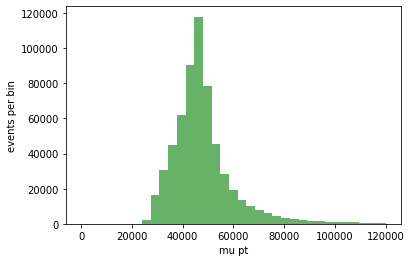

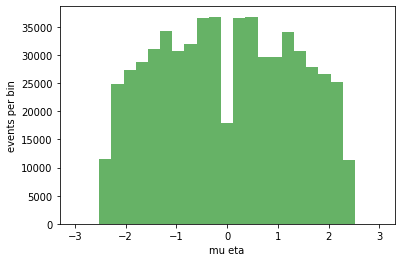

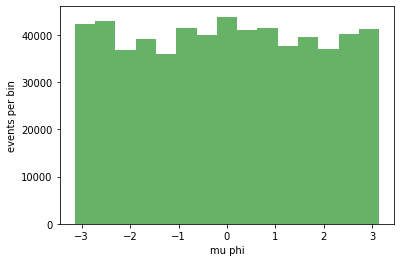

In [200]:
#let's make some simple histograms of the kineamtic information associated with the muons
# as an example I plot the leading, but you can easily plot the sub-leading muon kineamtics
# and compare

# plot the mu pt histogram.
plt.figure()
plt.xlabel("mu pt")
plt.ylabel("events per bin")
plt.hist(lvArray0.pt, bins=35, range=[0,120000], alpha=0.6, color='g')

# plot the mu pseudorapdity histogram.
plt.figure()
plt.xlabel("mu eta")
plt.ylabel("events per bin")
plt.hist(lvArray0.eta, bins=25, range=[-3.0,3.0], alpha=0.6, color='g')

# plot the mu phi histogram.
plt.figure()
plt.xlabel("mu phi")
plt.ylabel("events per bin")
plt.hist(lvArray0.phi, bins=15, range=[-3.14,3.14], alpha=0.6, color='g')

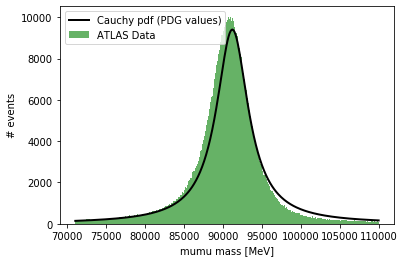

In [214]:
#now that we have reconstructed four-vectors of the dimuon system and know how to make histogram plots,
#let's make a histogram plot of the dimuon mass distribution and see if the Breit-Wigner(Cauchy) distribution
# can be seen and if the peak is somehwhere around 90 GeV

#we set up a few parmaters for our histogram, min and max of the x-axis (mass)
minMass = 71000
maxMass = 110000

#the number of bins
nBins = 300 

# creating the histogram as two arrays (bin edges & counts in the bins) numpy
countsData, edges = np.histogram(lvArray.mass, bins=nBins, range=(minMass, maxMass))

#we want to compare this histogram to a cauchy pdf to see if our ATLAS data
#agrees with the prediction from there. However, pdfs are always normalised to an area of 1
#while our data represents hundreds of thousands of events, so it's histogram will surely
#have an integral much larger than 1. Therefore we must first calculate this integral
# use it to scale our pdf. In that way we can make a fair visual comparison between the data
# histogram and the predicted Cauchy distribution.

# get the width of each bin
bin_width = edges[1] - edges[0]
# sum over number in each bin and mult. by bin width, which can be factored out.
# This gives us the integral
integral = bin_width * sum(countsData[0:nBins])

# we can make an array of the centre of each bin directly from the edges array
#this will be useful in plotting our pdf
centres = (edges[1:] + edges[:-1]) / 2

#fit a Cauchy distributions to the dimuon mass data
#mu, std = cauchy.fit(lvArray.mass)
#print("mu = " + str(mu))
#print("std = " + str(std))

# so we are almost ready to compare our data histogram with the predicted Cauchy distribution.
# but we know the Cauchy pdf has two free parameters: the mean (mu) and standard deviation (sigma).
# what should we choose for these values for a first comparison? Why not the world-average values
#published by the Particle Data group below...

mZPDG  = 91187.6
sigmaZPDG = 2495.2

#let's make the comparison plot
plt.figure()
p = (cauchy.pdf(centres, mZPDG, sigmaZPDG) * integral)
plt.plot(centres, p, 'k',label="Cauchy pdf (PDG values)", linewidth=2)
plt.hist(lvArray.mass, bins=nBins, range=[minMass, maxMass],label="ATLAS Data", alpha=0.6, color='g')
plt.legend()
plt.xlabel("mumu mass [MeV]")
plt.ylabel("# events")
plt.show()


In [ ]:
#the plot above shows a clear peak and a shape that looks very much like a cauchy distrubtion.
# so we can be sure that our data conatains the decays of a heavy particle to pairs of muons.
#Hoewever the data does not perfectly agree with the predicted shape of a cauchy distributions
# with the PDG values for the mass and width of the Z boson.

# In the next parts of this notebook we will try to assess if we can find values of the Z mass 
# which result in a better 'agreement' between the data and cauch model. If we trust the cauchy
# model completely, then this proceedure is a measurement of the z mass.

In [215]:
# we'll define the agreement between our data and model with the chi-squared function.
#the function take in arrays of events counts ('obs') and predictions ('preds') corresponding
#to the bins of the dimuon mass distribution. the function returns the squared difference
#between the event count and prediction divded by the variance on the prediction, summed
#over all bins, otherwise known as the chi-squared function.

#chi-squared function
def calcChiSq(obs, preds):
    chiSq = 0.0
    ndf = len(obs)
    for bin in range(0, len(obs)):
        diff = preds[bin] - obs[bin]
        #print("diff = " + str(diff))
        var = ( np.abs(preds[bin])) # approximate the of the prediction's statitical variance as the predicted value itself
        if (var != 0):
            chiSq += (diff**2)/(var)
            #print("obs, pred, diff, var  chi contrib = "+  str( obs[bin]) +" " +  str(preds[bin]) +" "+  str(diff) +" "+  str(var) +" " + str((diff**2)/(var)))
    return chiSq, ndf

final-chi2 = 14472.575797056992


<Figure size 432x288 with 0 Axes>

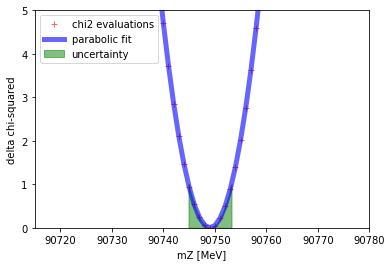

best-fit = 90749 +/- 4.117868060071487


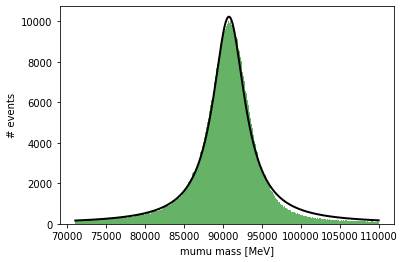

In [220]:
#we'll now loop over a range of Z mass values, generate a cuachy distribution for that value and evaluate
#the chi-squared between that distribution and the data histogram

#some arrays to hold the z mass and chi-squared values
mZAr = np.array([])
chi2Ar = np.array([])

#deciding the range of z mass values and how fine the steps in this range will be
minMz = 90715
maxMz = 90780
step = 1

#vairables to use in the loop to find value of z mass that gives smallest chi2
bestFitMz1D = 0.0
minChi2 = 10000000


for mZ in range(minMz, maxMz, step): #starting loop
    countsPDF = (cauchy.pdf(centres, mZ, sigmaZ) * integral) #building pdf for these values
    chi2, ndf = calcChiSq(countsData, countsPDF) # call chi2 function to get chi2 for this particular pdf and data
    mZAr = np.append(mZAr, mZ) #adding values to arrays
    chi2Ar = np.append(chi2Ar, chi2)
    if(chi2 < minChi2): #keeping track of what is the smallest chi2 value we have found
        minChi2 = chi2
        bestFitMz1D = mZ
                
print("final-chi2 = " + str(minChi2))

# as we will only be interested in the change in chi2 w.r.t. mZ,  we can rescale all the chi2
# values such that the minimum chi2 value is 0. 
chi2Ar = chi2Ar - minChi2

#we expect the chi2 vs. mZ plot to follow a 2nd order polynomial, so 
# let's see how well it does by fitting that fucntion to it.
z = np.polyfit(mZAr, chi2Ar, 2)
p = np.poly1d(z)


#lets plot our chi2 values vs mz along with the polynomial fit
plt.figure()
fig, ax = plt.subplots()
ax.plot(mZAr, chi2Ar, 'r+', lw=5, alpha=0.6, label="chi2 evaluations")
ax.plot(mZAr, p(mZAr), 'b-', lw=5, alpha=0.6, label="parabolic fit")

# we can display the estimated uncertianty on mZ via critical values () of the delta chi-squared curve
y0 = 1.0
crit = (p - y0).roots # roots of the polynominal -1, i.e., the mz values where p = 1 

#shading in the uncertainty band 
px=np.arange(crit[1],crit[0],0.001)
ax.fill_between(px,p(px),alpha=0.5, color='g', label="uncertainty")
ax.legend()

#setting reasonable axis ranges and titles
ax.set_xlim(minMz, maxMz)
ax.set_ylim(0.0, 5.0)
plt.xlabel("mZ [MeV]")
plt.ylabel("delta chi-squared")

plt.show()


#print result and uncertainty
my1DResult = bestFitMz1D
my1DUncertainty = bestFitMz1D-crit[1]
print("best-fit = " + str(my1DResult) + " +/- " + str(my1DUncertainty))




# we now compare our data histogram with the cauchy distribution with the mean 
# and standard deviation that minimise the chi-squared. This pdf should agree much better
# than the pdf with the PDG values.


plt.figure()
p = (cauchy.pdf(centres, my1DResult, sigmaZ))

pInt = bin_width * sum(p[0:nBins])
scale = integral/pInt
pScaled = (cauchy.pdf(centres, my1DResult, sigmaZ) *scale)

plt.plot(centres, pScaled, 'k', linewidth=2)
plt.hist(lvArray.mass, bins=nBins, range=[minMass, maxMass], alpha=0.6, color='g')
plt.xlabel("mumu mass [MeV]")
plt.ylabel("# events")
plt.show()

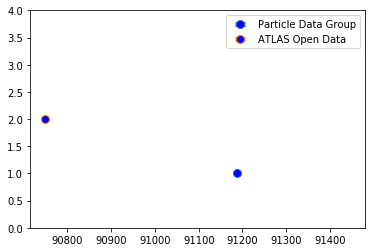

In [223]:
# now we have a 'measurement' of mZ, let's make a plot comparing our
# measured value with that from the PDG to assess how good our measurement is.

mZPDGAr = np.array([mZPDG]) 
uncZPDGAr = np.array([2.1]) 
yPDGAr = np.array([1.0]) 

mZ1D = np.array([my1DResult]) 
sigZ1D = np.array([my1DUncertainty]) 
y1D = np.array([2.0]) 

plt.figure()
ax = plt.gca()
ax.set_xlim(minMz, maxMz+700)#need to extend x axis range to include PDG value
ax.set_ylim(0.0, 4.0)

plt.errorbar(mZPDGAr, yPDGAr, xerr=uncZPDGAr, label="Particle Data Group", elinewidth=5,  fmt="o", mfc="blue", ms=8)
plt.errorbar(mZ1D, y1D, xerr=sigZ1D, fmt="o", label="ATLAS Open Data", elinewidth=5, ms=8, mfc='blue')

plt.legend()
plt.show()